In [1]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.11.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate , LeakyReLU, BatchNormalization , ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
import pandas as pd
import numpy as np
import cv2
# import imutils
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
def identity_block(input_tensor, kernel_size, filter_num, stage):
    x = layers.Conv2D(filter_num, (1,1))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter_num, kernel_size, padding ='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor,kernel_size,filter_num,stage,strides=(2, 2)):
    x = layers.Conv2D(filter_num, (1, 1), strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filter_num, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    shortcut = layers.Conv2D(filter_num, (1, 1), strides=strides)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [5]:
def sun_branch(x):
    x = layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding='same')(x)
    x = layers.Conv2D(32, kernel_size = 3 , strides= 1, padding = 'same')(x)
    x = layers.Activation('relu')(x)
    return x

In [6]:
def res_net_18(input_tensor):
    #input_tensor = Input(shape=(height, width, depth))

    x = layers.Conv2D(64, (7, 7),strides=(2, 2),padding='same',name='input')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding = 'same')(x)

    x = conv_block(x, 3, 64, stage=2, strides=(1, 1))
    c2 = identity_block(x, 3, 64, stage=2)

    x = conv_block(c2, 3, 128, stage=3)
    c3 = identity_block(x, 3, 128, stage=3)

    x = conv_block(c3, 3, 256, stage=4)
    c4 = identity_block(x, 3, 256, stage=4)

    x = conv_block(c4, 3, 512, stage=5)
    c5 = identity_block(x, 3, 512, stage=5)

    #model = Model(inputs=input_tensor , outputs = x)
    return c2, c3 , c4 ,c5

In [7]:
def lateral(x, out_channels):
    x = layers.Conv2D(out_channels, (1, 1), padding='same')(x)
    return  x
def upsampling_add(x,y):
    b,h,w,c = y.shape
    x = tf.image.resize(x, (h,w), method='bilinear')
    return layers.add([x,y])
def smooth(x):
    x = Conv2D(256, kernel_size = 3, strides = 1, padding ='same')(x)
    return x

In [8]:
def upsample_combined(input_tensor, target_shape):
    x = input_tensor
    x = tf.image.resize(x, target_shape, method='bilinear')
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [10]:
def mess_passing(x , mode):
    b,h,w,c = x.get_shape().as_list()
    if mode == 'H':
        feature_list_old = []
        feature_list_new = []
        for cnt in range(h):
            feature_list_old.append(tf.expand_dims(x[:, cnt, :, :], axis=1))
        feature_list_new.append(tf.expand_dims(x[:, 0, :, :], axis=1))
        t2d_layers = Conv2D(c, kernel_size = [1,9], strides = (1,1), padding ='same')
        relu = layers.Activation('relu',name='t2d_relu')
        feature = t2d_layers(feature_list_old[0])
        feature = relu(feature) + feature_list_old[1]
        feature_list_new.append(feature)

        for cnt in range(2, h):
            feature = t2d_layers(feature_list_new[cnt - 1])
            feature = relu(feature) + feature_list_old[cnt]
            feature_list_new.append(feature)


        feature_list_new.append(feature)
        feature_list_old = feature_list_new
        feature_list_new = []
        length = h - 1
        feature_list_new.append(feature_list_old[length])
        d2t_layers = Conv2D(c, kernel_size = [1,9], strides = (1,1), padding ='same')
        relu = layers.Activation('relu' ,  name='d2t_relu')
        feature = d2t_layers(feature_list_old[length])
        feature = relu(feature) + feature_list_old[length - 1]
        feature_list_new.append(feature)
        for cnt in range(2, h):
            feature = d2t_layers(feature_list_new[cnt - 1])
            feature = relu(feature) + feature_list_old[length - cnt]
            feature_list_new.append(feature)
        feature_list_new.reverse()
        processed_feature = tf.stack(feature_list_new, axis=1)
        processed_feature = tf.squeeze(processed_feature, axis=2)

        return processed_feature
    elif mode == 'W':
        feature_list_old = []
        feature_list_new = []


        for cnt in range(w):
            feature_list_old.append(tf.expand_dims(x[:, :, cnt, :], axis=2))
        feature_list_new.append(tf.expand_dims(x[:, :, 0, :], axis=2))
        l2r_layers = Conv2D(c, kernel_size = [9,1],  strides = (1,1), padding ='same')
        relu = layers.Activation('relu', name='l2r_relu')
        feature = l2r_layers(feature_list_old[0])
        feature = relu(feature) + feature_list_old[1]
        feature_list_new.append(feature)
        for cnt in range(2, w):
            feature = l2r_layers(feature_list_new[cnt - 1])
            feature = relu(feature) + feature_list_old[cnt]
            feature_list_new.append(feature)


        feature_list_old = feature_list_new
        feature_list_new = []
        length = w - 1
        feature_list_new.append(feature_list_old[length])

        r2l_layers =  Conv2D(c, kernel_size = [9,1],  strides = (1,1), padding ='same')
        relu = layers.Activation('relu', name='r2l_relu')
        feature = r2l_layers(feature_list_old[length])
        feature = relu(feature) + feature_list_old[length - 1]
        feature_list_new.append(feature)

        for cnt in range(2, w):
            feature = r2l_layers(feature_list_new[cnt - 1])
            feature = relu(feature) + feature_list_old[length - cnt]
            feature_list_new.append(feature)
        feature_list_new.reverse()
        processed_feature = tf.stack(feature_list_new, axis=2)
        processed_feature = tf.squeeze(processed_feature, axis=3)
        return processed_feature

    return b,h,w,c

In [30]:

input_tensor = Input(shape=(512, 512, 3))
c2, c3 , c4 ,c5  = res_net_18(input_tensor)
# print(c2.shape)
m5 = lateral(c5, 256)

m4_1 = lateral(c4,256)
m3_1 = lateral(c3,256)
m2_1 = lateral(c2,256)
m4  = upsampling_add(m5, m4_1)
m3  = upsampling_add(m4, m3_1)
m2  = upsampling_add(m3, m2_1)

p5 = smooth(m5)
p4 = smooth(m4)
p3 = smooth(m3)
p2 = smooth(m2)

p2_2 = Conv2D(16, kernel_size = 3, strides = 1, padding ='same')(p2)

spatial_row = sun_branch(p2_2)
spatial_row = sun_branch(spatial_row)
spatial_row = sun_branch(spatial_row)

spatial_col = sun_branch(p2_2)
spatial_col = sun_branch(spatial_col)
spatial_col = sun_branch(spatial_col)

row_feature = mess_passing(spatial_row, mode = 'H')
col_feature = mess_passing(spatial_col, mode = 'W')

final_row_feature = upsample_combined(row_feature,target_shape=(512,512) )
final_col_feature = upsample_combined(col_feature,target_shape=(512,512) )

final_row_feature = Conv2D(1, kernel_size = 1,strides = 1, padding ='same')(final_row_feature)
final_col_feature = Conv2D(1, kernel_size = 1,strides = 1, padding ='same')(final_col_feature)

row_final = tf.keras.layers.Activation('sigmoid')(final_row_feature)
# row_1D = tf.reduce_sum(final_row_feature,axis=2)
# row_1D= row_1D/512

col_final = tf.keras.layers.Activation('sigmoid')(final_col_feature)
# col_1D= tf.reduce_sum(col, axis= 1 )
# col_1D = col_1D/512

out = {"row" :row_final , "col":col_final  }
# row branch

model = Model(inputs=input_tensor , outputs = out)

In [31]:
model.output_shape

{'row': (None, 512, 512, 1), 'col': (None, 512, 512, 1)}

In [32]:
model.compile(optimizer='adam',loss = {'row': 'binary_crossentropy', 'col': 'binary_crossentropy'},metrics=['accuracy'])

# data

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import cv2
import numpy as np
import pandas as pd
from collections import defaultdict
import sys
import xml.etree.ElementTree as ET
from xml.dom import minidom
import requests
import tarfile

from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt

from matplotlib.patches import  Rectangle
from PIL import ImageFont, ImageDraw
import tensorflow as tf

In [14]:
import zipfile
source_data_path = '/content/drive/MyDrive/fintab_split_table_image.zip'
with zipfile.ZipFile(source_data_path, 'r') as zip_ref:
    zip_ref.extractall('/content/source_data')

In [15]:
data_path ="/content/source_data/fintab_split_table_image/"
final_data = pd.read_csv("/content/drive/MyDrive/final_dataframe_fintabnet_split.csv")
final_data

,0,1
0,HAL_2009_page_77-1.jpg,"[[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1..."
1,HAL_2005_page_92-1.jpg,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,HAL_2014_page_40-1.jpg,"[[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1..."
3,HAL_2009_page_49-1.jpg,"[[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1..."
4,HAL_2015_page_42-1.jpg,"[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1..."
...,...,...
4496,VRSK_2013_page_94-1.jpg,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4497,VRSK_2015_page_123-1.jpg,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4498,VRSK_2011_page_100-1.jpg,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1..."
4499,VRSK_2018_page_144-1.jpg,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [16]:
import ast
def convert_String_to_array(string_array):
    nested_list = ast.literal_eval(string_array)

    numpy_array_1 = np.array(nested_list[0])
    numpy_array_2 = np.array(nested_list[1])
    # print(numpy_array_1.shape)
    # print(numpy_array_2.shape)
    # numpy_array = np.concatenate((numpy_array_1, numpy_array_2), axis=0)
    return numpy_array_1 , numpy_array_2

In [63]:
def normalize_img(img):
    #norm_img = (img - img.min()) / (img.max() - img.min())
    norm_img = np.array(img,dtype= np.float32)/255.0
    return norm_img

In [35]:
def make_image_row(row ,h , w,  new_shape= (512,512)):
  img_row = np.zeros((h, w), dtype=np.uint8)
  mask_img_row = np.where(row ==1 )
  img_row[mask_img_row,:] = 1
  img_row = cv2.resize(img_row, new_shape)
  return np.array(img_row)

def make_image_col(col,h , w, new_shape= (512,512)):
  img_col = np.zeros((h, w), dtype=np.uint8)
  mask_img_col = np.where(col ==1 )
  img_col[:,mask_img_col] = 1
  img_col = cv2.resize(img_col, new_shape)
  return np.array(img_col)


In [64]:
class DataGenerator(tf.keras.utils.Sequence) :
    def __init__(self, data , batch_size= 1,dim = (1024,1024) , shuffle=True ):
        self.data= data
        self.indices= self.data.index.tolist()
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        image_input , gt_row, gt_col = self.data_generation(batch)
        image_input = Image.open(data_path + image_input)
        image_input = np.array(image_input)
        h,w,c = image_input.shape
        image_input = cv2.resize(image_input, (512,512))
        image_input = image_input.astype('float')
        image_input = normalize_img(image_input)
        image_input= np.expand_dims(image_input, axis= 0)
        row_image = make_image_row(gt_row, h, w)
        row_image = np.expand_dims(row_image, axis= 0)
        col_image = make_image_col(gt_col, h, w)
        col_image = np.expand_dims(col_image, axis= 0)

        #p = np.concatenate((c,d), axis = 0)
        return image_input , {"row" :  row_image, "col": col_image}
        #return x, {"tl_heatmap" : a, "br_heatmap":b, "tag_concat" :p , "tl_reg" :e, "br_reg"  : f , "tags_mask" :g }
        #return x, {"tl_heatmap" : a, "br_heatmap":b, "tl_tag" :c ,"br_tag":d, "tl_reg" :e, "br_reg"  : f , "tags_mask" :g }

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def data_generation(self, batch):
      for i , batch_id in enumerate(batch):
        image_input = self.data.iloc[batch_id, 0 ]
        data = self.data.iloc[batch_id ,1]
        data = data[1:-1]
        data_1 , data_2 = convert_String_to_array(data)
        #   image_input = data_path + image_input
        #   json_data = data_path + json_data
        #   image[i,]  = cv2.imread(image_input)
        # print(image_input)
        # data = data[0]
        gt_row =data_1 # data[0]
        gt_row = np.array(gt_row)
        gt_col =data_2 # data[1]
        gt_col = np.array(gt_col)
        #print(f'laod {heatmap_tl.shape}')
      return image_input , gt_row, gt_col

In [57]:
def raw_image(image, row, col):
    image_ = np.array(image)
    h,w,c = np.array(image_).shape

    mask_row_array = np.where(row == 1)
    mask_col_array = np.where(col == 1)
    image_[mask_row_array,:,:] = 0
    image_[:,mask_col_array,:] = 0
    plt.imshow(image_)
    plt.show()

def get_label_row_col(image, row, col, new_shape = (512,512),  draw_image = False):
    image = np.array(image)
    h,w,c = np.array(image).shape

    # row
    img_row = np.zeros((h, w), dtype=np.uint8)
    mask_img_row = np.where(row ==1 )
    img_row[mask_img_row,:] = 1
    img_row = cv2.resize(img_row, new_shape)
    row_label = img_row[:,1]
    #col
    img_col = np.zeros((h, w), dtype=np.uint8)
    mask_img_col = np.where(col ==1 )
    img_col[:,mask_img_col] = 1
    img_col = cv2.resize(img_col, new_shape)
    col_label = img_col[1,:]

    if draw_image == True:
        image_ = cv2.resize(image, new_shape)
        mask_row_array = np.where(row_label == 1)
        mask_col_array = np.where(col_label == 1)
        image_[mask_row_array,:,:] = 0
        image_[:,mask_col_array,:] = 0
        plt.imshow(image_)
        plt.show()
    else:
        image_ = cv2.resize(image, new_shape)
    return image_, row_label, col_label

In [65]:
image_input , gt = next(iter(DataGenerator(data=final_data[0:].reset_index(drop=True), batch_size=1)))

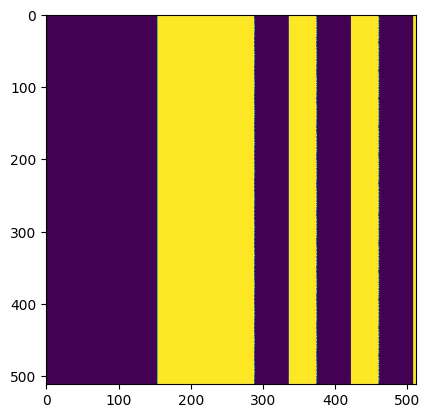

In [48]:
a = gt["col"][0]
plt.imshow(a)
plt.show()

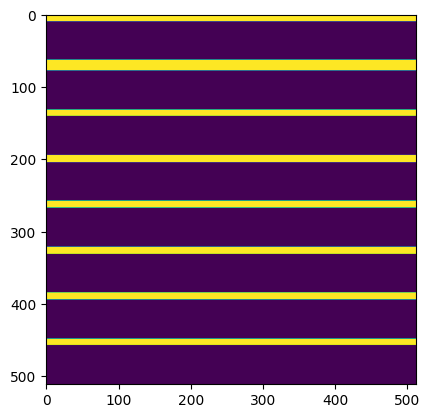

In [49]:
a = gt["row"][0]
plt.imshow(a)
plt.show()

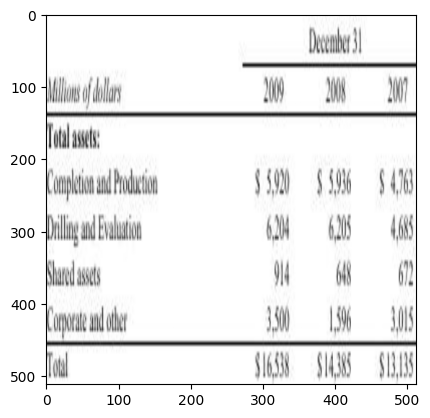

In [66]:
# image = Image.open(data_path + image_sample)
plt.imshow(np.array(image_input[0]))
plt.show()

In [46]:
# raw_image(image_input, gt["row"], gt["col"])

In [67]:
a,b,c = get_label_row_col(image_input, gt["row"], gt["col"], draw_image= True)

ValueError: too many values to unpack (expected 3)

# train

In [26]:
def custom_loss_function(row_true, row_pred, col_true, col_pred):
  row_loss = tf.keras.losses.binary_crossentropy(row_true, row_pred)
  col_loss = tf.keras.losses.binary_crossentropy(col_true, col_pred)
  row_loss_mean = tf.reduce_mean(row_loss)
  col_loss_mean = tf.reduce_mean(col_loss)
  total_loss = row_loss_mean + col_loss_mean
  return total_loss

In [68]:
training_generator = DataGenerator(data=final_data[:4000].reset_index(drop=True), batch_size=1)

In [ ]:
model.fit(training_generator, epochs= 2)

Epoch 1/2
 335/4000 [=>............................] - ETA: 9:56:58 - loss: 0.9935 - activation_65_loss: 0.4872 - activation_64_loss: 0.5062 - activation_65_accuracy: 0.7517 - activation_64_accuracy: 0.8050

In [28]:
# optimizer = tf.keras.optimizers.Adam()
# loss_list = []
# with open('/content/log_loss.txt','a') as file:
#    for epoch in range(5):
#     print(f'epoch : {epoch}')
#     for step , data in enumerate(training_generator):
#       image_input = data[0]
#       gt_row = data[1]
#       gt_col = data[2]
#       image_input, gt_row , gt_col = get_label_row_col(image_input,gt_row,gt_col  )
#       # print(image_input.shape)
#       # print(gt_row.shape)
#       # print(gt_col.shape)
#       image_input = np.expand_dims(image_input, axis=0)
#       gt_row = np.expand_dims(gt_row, axis=0)
#       gt_col = np.expand_dims(gt_col, axis=0)
#       with tf.GradientTape() as tape:
#         out_1, out_2 = model(image_input, training=True)
#         # print("aaaaaaaa")
#         # print(out_1)
#         # loss_1 = tf.keras.losses.binary_crossentropy(gt_row, out_1)
#         # print(loss_1.shape)
#         # loss_2 = tf.keras.losses.binary_crossentropy(gt_col, out_2)
#         loss = custom_loss_function(gt_row, out_1, gt_col, out_2)
#         file.write(f'epoch_{epoch}  step_{step}    :   {loss}\n')
#         print(f'epoch_{epoch}  step_{step}    :   {loss}')
#       gradients = tape.gradient(loss, model.trainable_variables)
#       optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#       loss_list.append(loss.numpy())
#     tg = tf.convert_to_tensor(loss_list)
#     epoch_loss = tf.reduce_sum(tg)
#     mean_epoch_loss = epoch_loss/len(loss_list)
#     loss_list.clear()
#     print(f'loss_value : {mean_epoch_loss}')
